In [1]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading necessary libraries to build and train model                       │
└──────────────────────────────────────────────────────────────────────────"""
import os,sys,gc
import numpy as np
import pickle
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import TimeDistributed as td
import proplot as plot
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/scikit/')
from tools import derive_var,read_and_proc
from tools.mlr import mlr
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
import read_stuff as read
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/tmp/ipykernel_409812/107484696.py:20: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [150]:
! pip install -q -U keras-tuner

In [2]:
from tqdm.auto import tqdm
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()

  0%|          | 0/20 [00:00<?, ?it/s]

In [3]:
from tools.validation import r2_analysis
class train_optimizedMLR:
    def __init__(self,folderpath=None,modelpath=None):
        self.pcapath=folderpath
        self.modelpath=modelpath
        self.pcastore = read_and_proc.depickle(self.pcapath+'PCAdict2D.pkg')
        self.flatarray = read_and_proc.depickle(self.pcapath+'flatarrays2D.pkg')
        
    def read_Xy(self,num=33):
        """
        Read in the processed PC loading time series
        """
        Xtest,Xtrain,Xvalid = [],[],[]
        yall = []
        for i in tqdm(range(num)):
            temp1,temp2,temp3,temp4 = read.real_random(self.modelpath,i,3,'keras')
            Xtest.append(temp1)
            Xtrain.append(temp2)
            Xvalid.append(temp3)
            yall.append(temp4)
        
        yall_orig = []
        for i in tqdm(range(num)):
            temp1,temp2,temp3,temp4 = read.real_random(self.modelpath,i,3,'orig')
            yall_orig.append(temp4)
        return Xtrain,Xvalid,Xtest,yall,yall_orig
    
    def delete_padding(self,inTS=None,outTS=None):
        output_nozero,input_nozero = [],[]
        for i in range(len(outTS[:,0])):
            temp = outTS[i,:]
            tempin = inTS[i,:]
            if temp.all()==0:
                continue
            else:
                output_nozero.append(temp)
                input_nozero.append(tempin)
        return input_nozero,output_nozero
        
    def y_truth(self,divider=None,lti=24,num=33):
        temp = [r2_analysis.preproc_r2(self.flatarray,None,None)._back_to_exp(timeseries=self.flatarray[varname],divider=divider) for varname in ['u','v','w','theta']]
        train_realUV,valid_realUV,test_realUV = [],[],[]
        for i in tqdm(range(num)):#range(15)):#range(1)):
            tempindex = read._get_exp_name(self.modelpath,i,3,'orig')[1]
            validindex,testindex = [int(tempindex[0]),int(tempindex[1])],[int(tempindex[2]),int(tempindex[3])]
            trainobj = r2_analysis.preproc_r2(self.flatarray,validindex,testindex).windrates_real(uvwheat=temp,LT=lti,category='train')
            validobj = r2_analysis.preproc_r2(self.flatarray,validindex,testindex).windrates_real(uvwheat=temp,LT=lti,category='valid')
            testobj = r2_analysis.preproc_r2(self.flatarray,validindex,testindex).windrates_real(uvwheat=temp,LT=lti,category='test')
            train_realUV.append(trainobj)
            valid_realUV.append(validobj)
            test_realUV.append(testobj)
        del trainobj,validobj,testobj
        gc.collect()
        return {'train':train_realUV,'valid':valid_realUV,'test':test_realUV}

In [5]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/'
folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/intermediate/'
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading input and outpus                    
└──────────────────────────────────────────────────────────────────────────"""
Xtrain,Xvalid,Xtest,yall,yall_orig = train_optimizedMLR(folderpath,folderpath2).read_Xy(num=33)
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading PC structures for custom loss                       
└──────────────────────────────────────────────────────────────────────────"""
pcastore = train_optimizedMLR(folderpath,folderpath2).pcastore
wcomps = [26,18,48,14]
upcs,vpcs,wpcs,thpcs = pcastore['u'].components_[:wcomps[0]],pcastore['v'].components_[:wcomps[1]],pcastore['w'].components_[:wcomps[2]],pcastore['theta'].components_[:wcomps[3]]
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading y truth for custom loss                      
└──────────────────────────────────────────────────────────────────────────"""
yTRUTH = train_optimizedMLR(folderpath,folderpath2).y_truth(divider=divider,lti=24,num=33)

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

In [6]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Which split will we be testing                     
└──────────────────────────────────────────────────────────────────────────"""
splitnum = 0

#### Build Models

In [7]:
from tensorflow.keras import layers

# Basic settings
startshape = Xtrain[0]['lwsw'].shape[1]
endshape = yall_orig[0][23][0].shape[1]
"""──────────────────────────────────────────────────────────────────────────┐
│ Define Input Layer
└──────────────────────────────────────────────────────────────────────────"""
inputs = keras.Input(shape=(startshape))

"""──────────────────────────────────────────────────────────────────────────----------
│ Step I: Finding the Optimal PC structures
| A lambda layer to divide long array into variable-specific chucks
| Dense layers with linear activation to find optimal PC weights for prediction task
└──────────────────────────────────────────────────────────────────────────------------"""
branch_output = []
brchindex = [0,30,60]

for ind,obj in enumerate(range(2)):
    # Slice Inputs and store in different channels
    branchs = layers.Lambda(lambda x: x[:, brchindex[ind]:brchindex[ind+1]])(inputs)
    # Setting up linear activated dense layers to store 'optimal PC structures
    dense_oPC = layers.Dense(1)
    # Setting up individual channels
    lyer = dense_oPC(branchs)
    branch_output.append(lyer)
    
"""──────────────────────────────────────────────────────────────────────────----------
│ Step II: Concatenate optimal PC structures
| A Concat layer to combine all optimal PC structures
└──────────────────────────────────────────────────────────────────────────------------"""    
# Concatenate channel outputs
concat = layers.Concatenate()
concatlyer = concat(branch_output)

"""──────────────────────────────────────────────────────────────────────────----------
│ Step III: Make Prediction
| A final dense layer to link optimal PC structures and outputs
└──────────────────────────────────────────────────────────────────────────------------"""
dense_PC_out = layers.Dense(endshape)
out = dense_PC_out(concatlyer)

2022-10-24 21:36:50.966965: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-24 21:36:50.969336: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
from keras import backend as K

class PCreconstructLoss():
    def __init__(self,wcomps=[26,18,48,14],splitnum=splitnum,upcs=None,vpcs=None,wpcs=None,thpcs=None,uvar=None,vvar=None,wvar=None,thvar=None):
        self.__name__ = "reconloss"
        self.wcomps = wcomps
        self.splitnum = splitnum
        self.upcs=upcs
        self.vpcs=vpcs
        self.wpcs=wpcs
        self.thpcs=thpcs
        self.uvar=uvar
        self.vvar=vvar
        self.wvar=wvar
        self.thvar=thvar
    
    def custom_score(self,truth=None,predict=None,var=None):
        RSS = K.sum(K.square( truth - predict ))
        TSS = var#K.sum(K.square( truth - K.mean(truth) ))
        return (1-RSS/(TSS) )
    
    def __call__(self, y_true, y_pred):
        ############################################################################################################
        # PC reconstruction
        ############################################################################################################
        # Eigenvectors
        ############################################################################################################
        #u_pc,v_pc,w_pc,th_pc = tf.Variable(self.upcs),tf.Variable(self.vpcs),tf.Variable(self.wpcs),tf.Variable(self.thpcs)
        urecon_pred = K.dot( y_pred[:,0:self.wcomps[0]], (self.upcs) )
        vrecon_pred = K.dot( y_pred[:,self.wcomps[0]:self.wcomps[0]+self.wcomps[1]], (self.vpcs) )
        wrecon_pred = K.dot( y_pred[:,self.wcomps[0]+self.wcomps[1]:self.wcomps[0]+self.wcomps[1]+self.wcomps[2]], (self.wpcs) )
        threcon_pred = K.dot( y_pred[:,self.wcomps[0]+self.wcomps[1]+self.wcomps[2]:self.wcomps[0]+self.wcomps[1]+self.wcomps[2]+self.wcomps[3]], (self.thpcs) )
        
        ############################################################################################################
        # r2 calculation
        ############################################################################################################
        # Output truth
        ############################################################################################################
        urecon_truth = K.dot( y_true[:,0:self.wcomps[0]], (self.upcs) )
        vrecon_truth = K.dot( y_true[:,self.wcomps[0]:self.wcomps[0]+self.wcomps[1]], (self.vpcs) )
        wrecon_truth = K.dot( y_true[:,self.wcomps[0]+self.wcomps[1]:self.wcomps[0]+self.wcomps[1]+self.wcomps[2]], (self.wpcs) )
        threcon_truth = K.dot( y_true[:,self.wcomps[0]+self.wcomps[1]+self.wcomps[2]:self.wcomps[0]+self.wcomps[1]+self.wcomps[2]+self.wcomps[3]], (self.thpcs) )
        
        r2_u = self.custom_score( urecon_truth, urecon_pred, self.uvar)
        r2_v = self.custom_score( vrecon_truth, vrecon_pred, self.vvar)
        r2_w = self.custom_score( wrecon_truth, wrecon_pred, self.wvar)
        r2_th = self.custom_score( threcon_truth, threcon_pred, self.thvar)
        
        loss = ( r2_u + r2_v + r2_w + r2_th ) / 4
        
        return -loss
    
class customr2():
    def __init__(self,wcomps=[26,18,48,14]):
        self.__name__ = "customr2"
        self.wcomps = wcomps
    
    def r_2_score(self,truth=None,predict=None):
        RSS = K.sum(K.square( truth - predict ))
        TSS = K.sum(K.square( truth - K.mean(truth) ))
        return ( 1. - RSS/(TSS) )
    
    def __call__(self, y_true, y_pred):
        ############################################################################################################
        # Truth and prediction
        ############################################################################################################
        utruth,vtruth,wtruth,thtruth = y_true[0:self.wcomps[0]],y_true[self.wcomps[0]:self.wcomps[0]+self.wcomps[1]],y_true[self.wcomps[0]+self.wcomps[1]:self.wcomps[0]+self.wcomps[1]+self.wcomps[2]],\
        y_true[self.wcomps[0]+self.wcomps[1]+self.wcomps[2]:self.wcomps[0]+self.wcomps[1]+self.wcomps[2]+self.wcomps[3]]

        upred,vpred,wpred,thpred = y_pred[0:self.wcomps[0]],y_pred[self.wcomps[0]:self.wcomps[0]+self.wcomps[1]],y_pred[self.wcomps[0]+self.wcomps[1]:self.wcomps[0]+self.wcomps[1]+self.wcomps[2]],\
        y_pred[self.wcomps[0]+self.wcomps[1]+self.wcomps[2]:self.wcomps[0]+self.wcomps[1]+self.wcomps[2]+self.wcomps[3]]
        ############################################################################################################
        # r2 calculation
        ############################################################################################################
        r2_u = self.r_2_score( utruth, upred )
        r2_v = self.r_2_score( vtruth, vpred )
        r2_w = self.r_2_score( wtruth, wpred )
        r2_th = self.r_2_score( thtruth, thpred )
        avgr2 = ( r2_u + r2_v + r2_w + r2_th ) / 4
        return avgr2

In [9]:
model = keras.Model(inputs=[inputs],outputs=out, name='tcg2d_model')
model.summary()

Model: "tcg2d_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 lambda (Lambda)                (None, 30)           0           ['input_1[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 30)           0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1)            31          ['lambda[0][0]']                 
                                                                                        

#### Compile settings

In [10]:
X_totrain,y_totrain = train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtrain[0]['lwsw'],yall_orig[0][23][0])
X_tovalid,y_tovalid = train_optimizedMLR(folderpath,folderpath2).delete_padding(Xvalid[0]['lwsw'],yall_orig[0][23][1])
X_totest,y_totest = train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtest[0]['lwsw'],yall_orig[0][23][2])

In [11]:
np.asarray(y_totrain)

array([[-2.93415221e-04, -9.39321140e-05,  1.98521893e-04, ...,
         1.43864615e-04,  6.15286509e-05,  6.73797656e-05],
       [-2.96336553e-04, -7.81195646e-05,  2.52704436e-04, ...,
         1.37679343e-04,  6.88196371e-05,  6.72756894e-05],
       [-2.88555212e-04, -6.42767921e-05,  3.04385342e-04, ...,
         1.32184708e-04,  7.32183945e-05,  6.56532543e-05],
       ...,
       [-1.04901408e-03, -4.47080342e-05,  8.41967866e-05, ...,
        -9.49851636e-05,  2.07941077e-06, -1.18948621e-04],
       [ 9.11483943e-05, -2.96672341e-04,  1.33688007e-04, ...,
        -1.64982175e-04,  1.26087146e-04, -4.96985118e-06],
       [ 8.21949565e-05, -2.94061906e-04,  1.45447959e-04, ...,
        -1.64423493e-04,  1.12666681e-04, -3.15862341e-06]])

In [12]:
uvar = np.var(np.asarray(y_totrain)[:,0:26])
vvar = np.var(np.asarray(y_totrain)[:,26:26+18])
wvar = np.var(np.asarray(y_totrain)[:,26+18:26+18+48])
thvar = np.var(np.asarray(y_totrain)[:,26+18+48:26+18+48+14])

In [19]:
callback_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
#callback_checkpoint = tf.keras.callbacks.ModelCheckpoint('./tmp/try1/',save_best_only=True,monitor='val_loss',mode='min')

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-28),
              loss=PCreconstructLoss(wcomps=[26,18,48,14],splitnum=splitnum,\
                                     upcs=tf.Variable(np.float32(upcs)),vpcs=tf.Variable(np.float32(vpcs)),wpcs=tf.Variable(np.float32(wpcs)),thpcs=tf.Variable(np.float32(thpcs)),\
                                    uvar=tf.Variable(np.float32(uvar)),vvar=tf.Variable(np.float32(vvar)),wvar=tf.Variable(np.float32(wvar)),thvar=tf.Variable(np.float32(thvar))))
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-22),
#              loss="mean_squared_error")#PCreconstructLoss(wcomps=[26,18,48,14],splitnum=splitnum,\
                   #                  upcs=tf.Variable(np.float32(upcs)),vpcs=tf.Variable(np.float32(vpcs)),wpcs=tf.Variable(np.float32(wpcs)),thpcs=tf.Variable(np.float32(thpcs)),\
                   #                 uvar=tf.Variable(np.float32(uvar)),vvar=tf.Variable(np.float32(vvar)),wvar=tf.Variable(np.float32(wvar)),thvar=tf.Variable(np.float32(thvar))))

In [21]:
history = model.fit(np.asarray(X_totrain),np.asarray(y_totrain), 
                     epochs=10,
                    callbacks=callback_earlystop,
                    validation_data=(np.asarray(X_tovalid), np.asarray(y_tovalid)),
                    verbose=2,batch_size=8)

Epoch 1/10
103/103 - 1s - loss: 103075987456.0000 - val_loss: 52819951616.0000 - 1s/epoch - 12ms/step
Epoch 2/10
103/103 - 5s - loss: 102637412352.0000 - val_loss: 52819951616.0000 - 5s/epoch - 48ms/step
Epoch 3/10
103/103 - 9s - loss: 103090143232.0000 - val_loss: 52819951616.0000 - 9s/epoch - 87ms/step
Epoch 4/10


KeyboardInterrupt: 

In [19]:
test_score = model.evaluate(np.asarray(X_totest),np.asarray(y_totest),verbose=2)
print(f"Test loss: {test_score[0]}, Test accuracy: {test_score[1]}")

4/4 - 0s - loss: 181936177152.0000 - 16ms/epoch - 4ms/step


TypeError: 'float' object is not subscriptable

In [36]:
test_score = model.evaluate(np.asarray(Xin),np.asarray(yin),verbose=2)
print(f"Test loss: {test_score[0]}, Test accuracy: {test_score[1]}")

29/29 - 0s - loss: 2.0730e-08 - r_2_score: 0.7039 - 137ms/epoch - 5ms/step
Test loss: 2.0729892469262268e-08, Test accuracy: 0.7038987278938293


In [40]:
from tools.validation import r2_analysis
from sklearn.metrics import mean_squared_error, r2_score

In [42]:
??r2_score

Signature:
r2_score(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    multioutput='uniform_average',
    force_finite=True,
)
Source:   
def r2_score(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    multioutput="uniform_average",
    force_finite=True,
):
    """:math:`R^2` (coefficient of determination) regression score function.

    Best possible score is 1.0 and it can be negative (because the
    model can be arbitrarily worse). In the general case when the true y is
    non-constant, a constant model that always predicts the average y
    disregarding the input features would get a :math:`R^2` score of 0.0.

    In the particular case when ``y_true`` is constant, the :math:`R^2` score
    is not finite: it is either ``NaN`` (perfect predictions) or ``-Inf``
    (imperfect predictions). To prevent such non-finite numbers to pollute
    higher-level experiments such as a grid search cross-validation, by default
    these cases are replaced with 1.0 (perfect pre

In [44]:
r2_score(np.asarray(yin).transpose(),model.predict(np.asarray(Xin)).transpose())

0.6732310277499243

In [154]:
divider

array([ 103,  180,  267,  378,  473,  557,  664,  751,  786,  818,  924,
        991, 1063, 1150, 1250, 1287, 1371, 1459, 1539, 1565])

In [391]:
from sklearn.metrics import mean_squared_error

In [405]:
mean_squared_error(yin,model.predict(np.asarray(Xin)))

2.153033501777804e-08

In [22]:
model.predict(np.asarray(X_totrain))

array([[ 1.82698190e-01,  1.76899254e-01, -2.44717106e-01, ...,
         8.59387293e-02,  4.80856143e-05, -2.36925855e-02],
       [ 2.17362538e-01,  2.12328106e-01, -2.91626185e-01, ...,
         1.03922755e-01, -8.35805782e-04, -2.77178492e-02],
       [ 2.73456454e-01,  2.77436644e-01, -3.69526088e-01, ...,
         1.40024781e-01, -5.99073246e-03, -3.22709680e-02],
       ...,
       [-5.64523816e-01, -2.40098849e-01,  6.77670002e-01, ...,
         1.03304964e-02, -1.46932572e-01,  1.50472656e-01],
       [-1.15397882e+00, -4.05246168e-01,  1.36335981e+00, ...,
         9.81220379e-02, -3.41325909e-01,  3.29157412e-01],
       [-1.11489642e+00, -4.18693513e-01,  1.32414424e+00, ...,
         7.03423917e-02, -3.16753536e-01,  3.11160147e-01]], dtype=float32)

<AxesSubplot:ylabel='Density'>

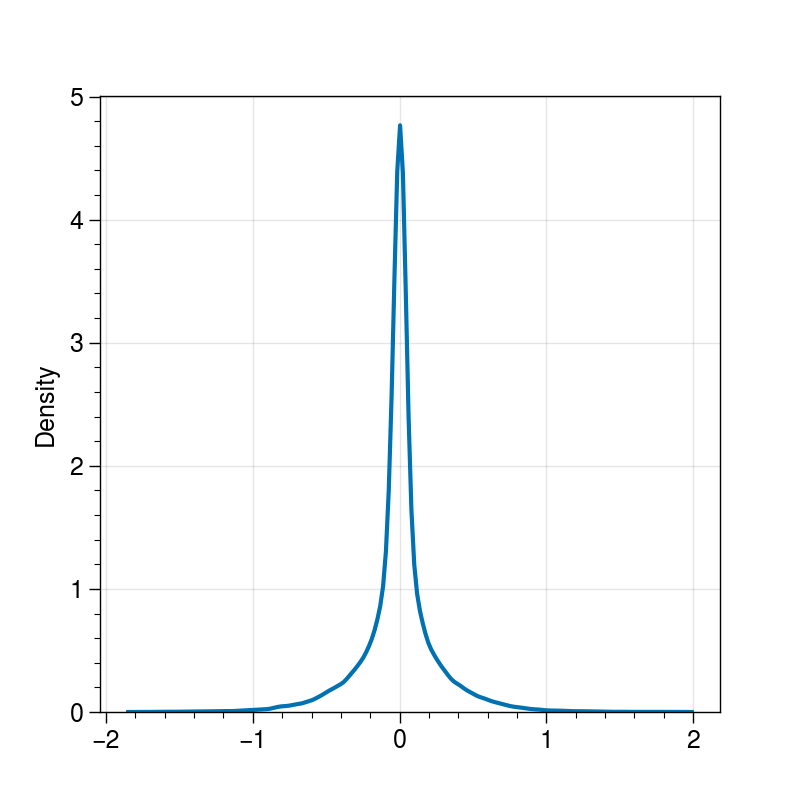

In [72]:
import seaborn as sns
sns.kdeplot(model.predict(np.asarray(X_totrain)).flatten())

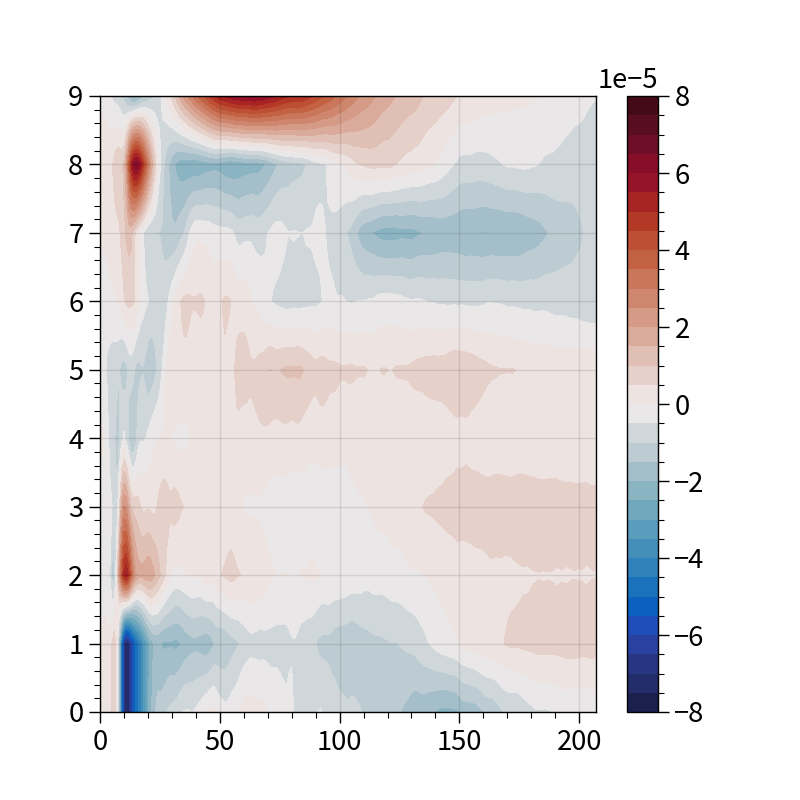

In [414]:
plt.contourf(train_realUV[6]['du'].reshape(-1,10,208)[443,:],cmap='balance',levels=np.linspace(-8e-5,8e-5,33))
plt.colorbar()
plt.show()

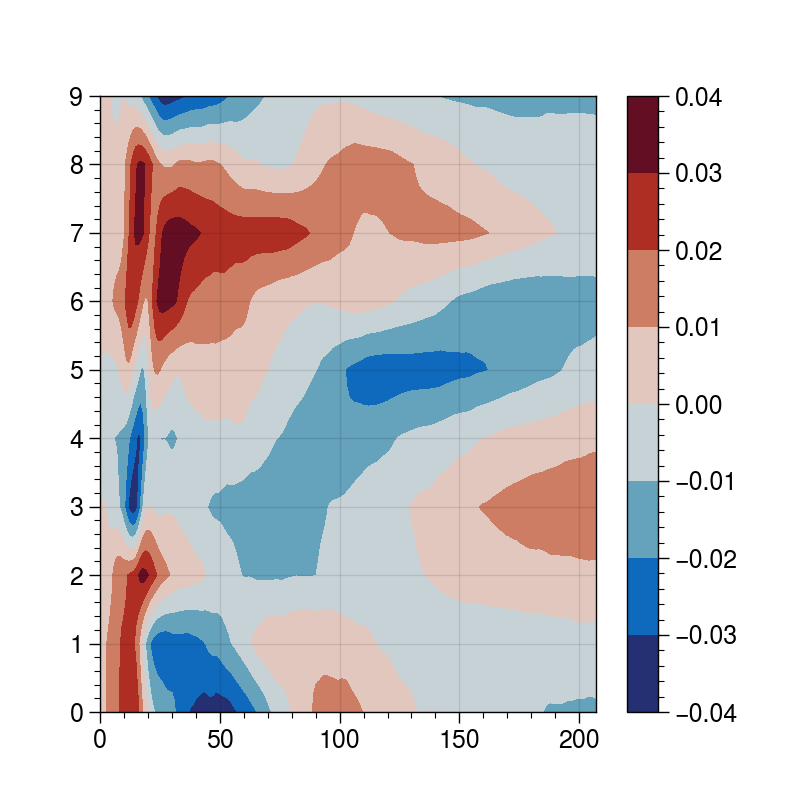

In [73]:
plt.contourf(np.dot(model.predict(np.asarray(X_totrain))[:,0:26],pcastore['u'].components_[:26]).reshape(-1,10,208)[443,:],cmap='balance')#,#levels=np.linspace(-8e-5,8e-5,33))
plt.colorbar()
plt.show()

#### Look at weights

In [74]:
model.layers[3].get_weights()

[array([[ 0.26921672],
        [ 0.17485666],
        [ 0.3492399 ],
        [ 0.4056319 ],
        [ 0.31425792],
        [ 0.32342756],
        [ 0.2018066 ],
        [-0.05551839],
        [-0.386247  ],
        [ 0.1486547 ],
        [-0.39265558],
        [-0.26220167],
        [ 0.39212167],
        [-0.3620992 ],
        [-0.07288   ],
        [ 0.42523068],
        [-0.21233162],
        [-0.22809379],
        [ 0.07810313],
        [-0.20211206],
        [-0.23516381],
        [-0.00689989],
        [-0.2875014 ],
        [-0.39495414],
        [-0.00421879],
        [ 0.27904695],
        [-0.18611822],
        [ 0.20401353],
        [ 0.35430163],
        [-0.19420387]], dtype=float32),
 array([-9.3537206e-17], dtype=float32)]

In [46]:
model.layers[3].get_weights()

[array([[-0.06242218],
        [ 0.3017761 ],
        [ 0.15340842],
        [ 0.12148643],
        [ 0.24343011],
        [-0.22423044],
        [-0.05104556],
        [-0.17012079],
        [ 0.04526864],
        [-0.25253937],
        [ 0.04693864],
        [ 0.27943644],
        [ 0.16483934],
        [-0.20880504],
        [-0.1471836 ],
        [ 0.10581565],
        [ 0.12002915],
        [ 0.26137185],
        [ 0.3069296 ],
        [-0.23095861],
        [ 0.2437542 ],
        [ 0.29205424],
        [-0.13848667],
        [-0.00928341],
        [-0.06708007],
        [-0.21302654],
        [ 0.08165047],
        [ 0.23227215],
        [ 0.27175093],
        [ 0.09822967]], dtype=float32),
 array([-0.01553231], dtype=float32)]

In [35]:
import seaborn as sns

In [144]:
testt = [np.multiply(obj,pcastore['lw'].components_[ind,:]) for ind,obj in enumerate(((model.layers[3].get_weights())[0]).transpose()[0])]

/tmp/ipykernel_3562373/89783688.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


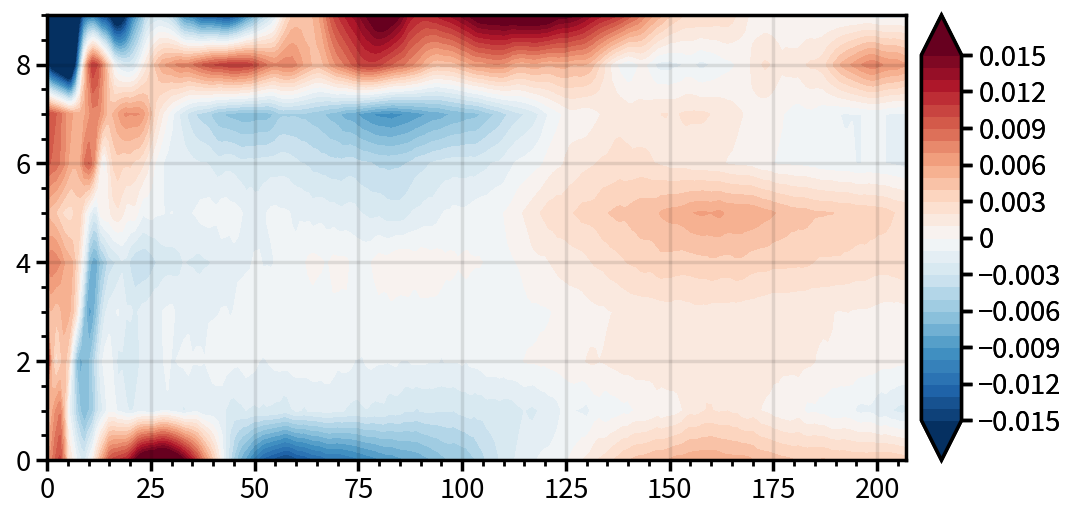

In [149]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig, ax1 = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.931,share=False)
sds = ax1.contourf(np.sum(np.asarray(testt),axis=0).reshape(10,208),cmap='RdBu_r',levels=np.linspace(-0.015,0.015,31),extend='both')
ax1.colorbar(sds)
plt.show()

/tmp/ipykernel_3562373/4094011208.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


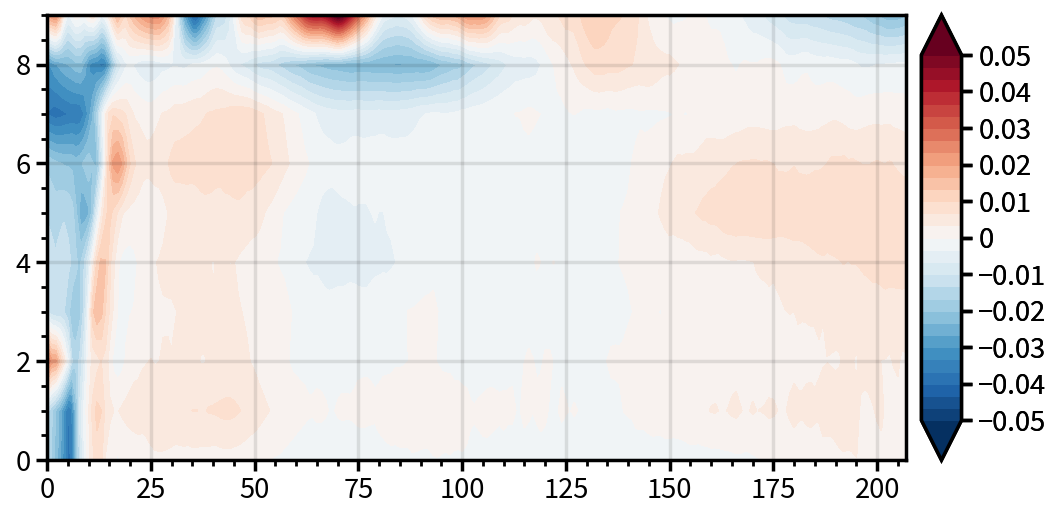

In [134]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig, ax1 = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.931,share=False)
sds = ax1.contourf(np.sum(np.asarray(testt),axis=0).reshape(10,208),cmap='RdBu_r',levels=np.linspace(-0.05,0.05,31),extend='both')
ax1.colorbar(sds)
plt.show()

In [147]:
timeseries = [np.multiply(obj,pcastore['lw'].transform(haiyan_data['lw'])[:,ind]) for ind,obj in enumerate(((model.layers[3].get_weights())[0]).transpose()[0])]

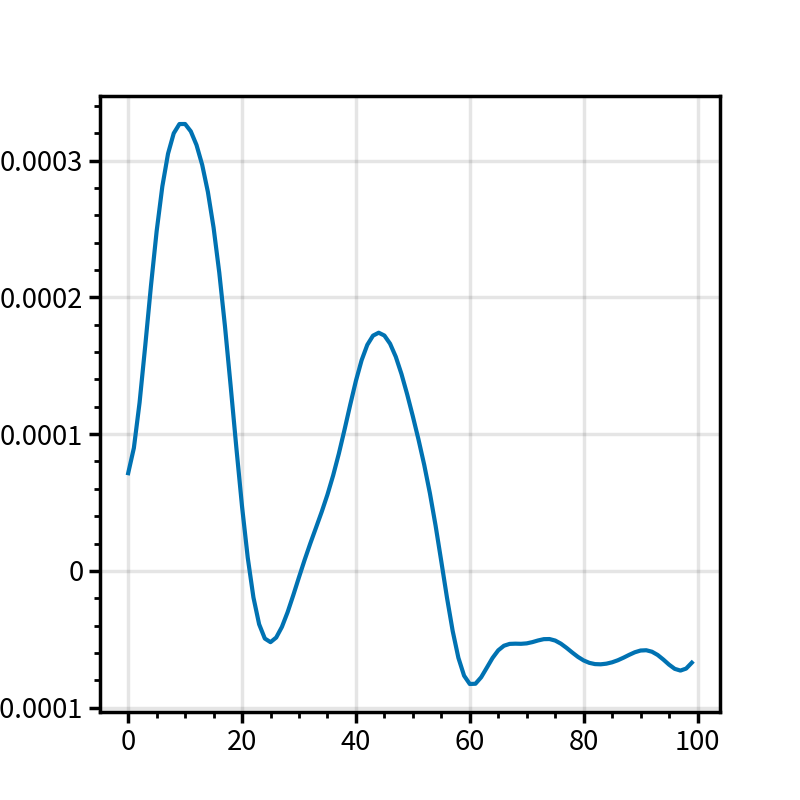

In [148]:
plt.plot(np.sum(np.asarray(timeseries),axis=0)[0:100])
plt.show()

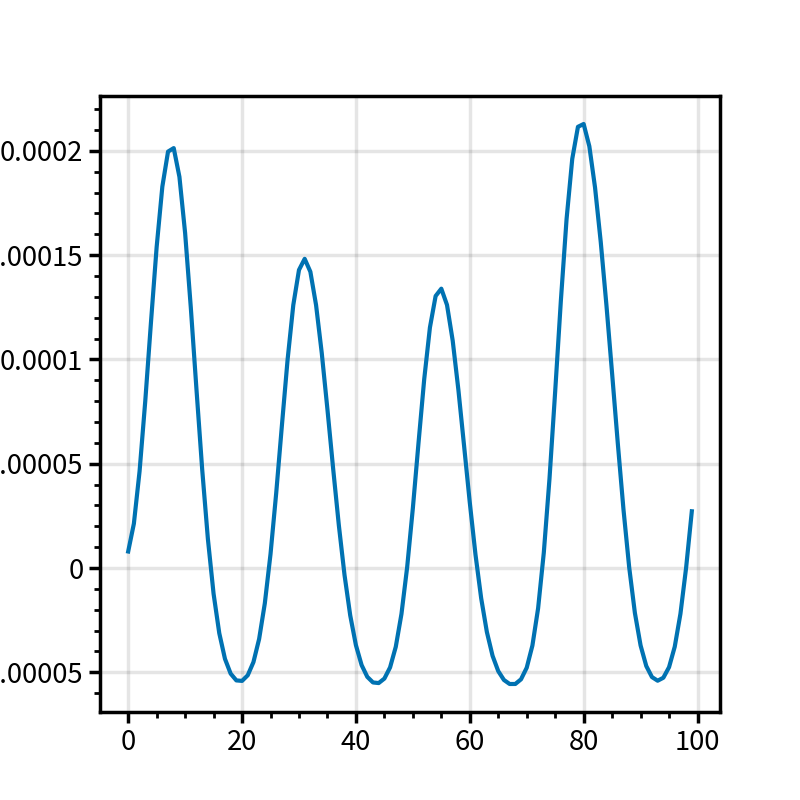

In [128]:
plt.plot(np.sum(np.asarray(timeseries),axis=0)[0:100])
plt.show()